#  Classificação de Gatos e Cachorros com Transfer Learning

## 📌 Introdução
Neste projeto utilizamos **Transfer Learning** para resolver o problema de classificação binária entre imagens de **gatos** e **cachorros**.

O Transfer Learning consiste em **reaproveitar uma rede neural já treinada em um grande dataset (ex.: ImageNet)** e adaptá-la para uma nova tarefa específica.

Aqui, utilizamos uma rede pré-treinada como extratora de características e adicionamos uma nova camada de classificação para identificar gatos e cachorros.


## ⚙️ Passos do Projeto
1. **Configuração do ambiente** → GPU no Google Colab.
2. **Preparação do dataset** → extração, organização e carregamento.
3. **Pré-processamento das imagens** → normalização, resize e divisão treino/validação.
4. **Construção do modelo com Transfer Learning** → uso da rede pré-treinada (VGG16 ou MobileNetV2).
5. **Treinamento do modelo** → apenas a camada final é ajustada.
6. **Avaliação e visualização dos resultados** → métricas e gráficos.
7. **Conclusão** → análise dos resultados obtidos.


# Verificar versão do python e do tensor
Aqui estão os comandos para verificar qual a versão do python intalada no colab e do tensorflow.
Irei alterar o tipo de processamento, alterando da CPU para GPU do colab para obter uma melhor performance do ambiente colab

In [ ]:
import tensorflow as tf
import sys

print("Versão do tensorflow",tf.__version__)
print("Versão do python", sys.version)
print("GPU disponível", tf.config.list_physical_devices('GPU'))

Versão do tensorflow 2.19.0
Versão do python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
GPU disponível [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Importando as bibliotecas

## Manipulação de dados
**OS**: Utilizada para interagir com o sistema operacional. É usada para tarefas como criar, renomear, mover e excluir pastas e arquivos, além de listar o conteúdo de diretórios. É uma biblioteca nativa do Python
**zipfile**: Foi utilizada para descompactar os arquivos compactados.

## Visualização dos dados
**Matplotlib:** Ferramenta utilizada para criar gráficos estáticos, animados e interativos em Python.

## Ferramentas de Machine Learning e Deep Learning

**Tensorflow:** Uma das plataformas de machine learning mais populares e robustas, criada pelo Google. O TensorFlow é um ecossistema de ferramentas, bibliotecas e recursos que permite aos desenvolvedores construir e implantar modelos de ML. É a espinha dorsal para o treinamento de redes neurais profundas.

**tensorflow.keras.applications.VGG16:** VGG16 é uma arquitetura de rede neural convolucional (CNN) pré-treinada em um grande conjunto de dados de imagens chamado ImageNet. Usar modelos pré-treinados como o VGG16 é uma técnica de transfer learning. Foi escolhido essa arquitetura devido a sua robustes e como foi utilizado uma GPU nesse projeto, achei mais interessante utilizar essa arquitetura para ter uma maior precisão possível.

**tensorflow.keras.layers:** Este módulo contém as diferentes "camadas" que compõem uma rede neural. As camadas são os blocos de construção dos modelos, cada uma com uma função específica. Por exemplo, a camada Dense é uma camada totalmente conectada, enquanto a camada Conv2D é usada para extrair características em imagens.

**tensorflow.keras.models:** O módulo models permite a criação e gerenciamento dos modelos. As duas classes mais comuns são Sequential (para modelos onde as camadas são empilhadas em sequência) e Model (para modelos mais complexos, com múltiplas entradas e saídas). É aqui que você define a arquitetura do seu modelo, combinando as camadas do layers


In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


In [ ]:
import os

zip_path = "/content/kagglecatsanddogs_5340.zip"
print(os.path.exists(zip_path))  # deve retornar True


True


##CAREEGAR DATASET
Depois de carregar o arquivo zip no colab, deverá ser descompactado e conferido a estrutura

In [ ]:
import zipfile
import os

# Caminho do arquivo já carregado
zip_path = "/content/kagglecatsanddogs_5340.zip"
extract_path = "/content/dataset"

# Extração
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Conferindo a estrutura extraída
print(os.listdir(extract_path))


['CDLA-Permissive-2.0.pdf', 'readme[1].txt', 'PetImages']


In [ ]:
data_dir = os.path.join("dataset", "PetImages")
os.listdir(data_dir)

['Dog', 'Cat']

##Preparar diretórios

Essas linhas estão localizando a pasta que contém as imagens e listando o que está dentro dela.

In [ ]:
base_dir = "dataset/PetImages"

train_dir = os.path.join(base_dir)
print(os.listdir(train_dir))


['Dog', 'Cat']


##Pré-processamento das imagens
Preparando e organizando as imagens para treinar um modelo de forma eficiente, sendo:

Definindo regras de preparação: O **ImageDataGenerator** configura o pré-processamento, como redimensionar todas as imagens, e cria variações aleatórias (rotação, zoom, etc.) para evitar que o modelo decore os dados.

Criando um gerador de treinamento: O **train_generator** lê as imagens de uma pasta, aplica as regras de preparação e as variações, e as organiza em pequenos lotes (batch) para alimentar o modelo durante o treino.

Criando um gerador de validação: O **val_generato**r faz o mesmo, mas usa uma parte separada das imagens (20% do total) para validar o desempenho do modelo, garantindo que ele aprenda a generalizar e não apenas a memorizar os dados.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% para validação
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


##Removendo imagens corrompidas

Removendo as imagens que apresentam algum problema para não atrapalhar o treinamento do modelo

In [ ]:
import os
from PIL import Image

base_dir = "dataset/PetImages"
cat_dir = os.path.join(base_dir, "Cat")
dog_dir = os.path.join(base_dir, "Dog")

def remove_corrupted_images(directory):
    print(f"Checking directory: {directory}")
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            img = Image.open(filepath)
            img.verify() # Verify that it is an image
        except (IOError, SyntaxError, Image.DecompressionBombError) as e:
            print(f"Removing corrupted image: {filepath} - Error: {e}")
            os.remove(filepath)

remove_corrupted_images(cat_dir)
remove_corrupted_images(dog_dir)

print("Finished checking and removing corrupted images.")

Checking directory: dataset/PetImages/Cat
Checking directory: dataset/PetImages/Dog


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Finished checking and removing corrupted images.


##Transfer Learning com VGG16

**Layer (type):** Nome da camada e tipo.
**Output Shape:** O formato do tensor (saída da camada).
**Param #:** Quantidade de parâmetros (pesos e vieses) daquela camada.

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # congela pesos

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

##Treinamento
Treinando o modelo de inteligência artificial por 10 vezes completas, usando os dados de treinamento fornecidos. Ao mesmo tempo emque se monitora o desempenho do modelo a cada volta (época) com um conjunto de dados separado para garantir que o modelo está realmente aprendendo de forma eficaz e não apenas memorizando.

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 54/625 ━━━━━━━━━━━━━━━━━━━━ 2:27 257ms/step - accuracy: 0.6354 - loss: 0.8565

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 246s 387ms/step - accuracy: 0.7860 - loss: 0.4725 - val_accuracy: 0.8527 - val_loss: 0.3274
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 325ms/step - accuracy: 0.8421 - loss: 0.3509 - val_accuracy: 0.8723 - val_loss: 0.2931
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 326ms/step - accuracy: 0.8563 - loss: 0.3202 - val_accuracy: 0.8794 - val_loss: 0.2891
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 317ms/step - accuracy: 0.8670 - loss: 0.3079 - val_accuracy: 0.8701 - val_loss: 0.2845
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 320ms/step - accuracy: 0.8643 - loss: 0.3104 - val_accuracy: 0.8794 - val_loss: 0.2781
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 315ms/step - accuracy: 0.8725 - loss: 0.2914 - val_accuracy: 0.8741 - val_loss: 0.2892
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - accuracy: 0.8716 - loss: 0.2914 - val_accuracy: 0.8800 - val_loss: 0.2743
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 311ms/step - accuracy: 0.8682 - loss: 0.29

##Visualização dos resultados
**Acurácia:**: É a métrica mais intuitiva e simples de entender. Ela mede a porcentagem de previsões corretas que o seu modelo fez. Em outras palavras, é a proporção de casos em que o modelo acertou em relação ao total de casos avaliados.

**Perda**: A perda, ou função de perda (loss function), é uma métrica que quantifica o quão "erradas" são as previsões do seu modelo. Ao contrário da acurácia, que é uma métrica de desempenho geral, a perda é usada para guiar o processo de treinamento do modelo. O objetivo do treinamento é encontrar os parâmetros do modelo que minimizem essa perda.

Durante o treinamento de um modelo deve-se observa ambas as métricas evoluindo. Idealmente, a perda no conjunto de dados de treinamento (e de validação) diminui, indicando que o modelo está aprendendo e fazendo previsões melhores. Ao mesmo tempo, a acurácia no conjunto de validação deve aumentar, mostrando que o modelo está generalizando bem para novos dados.

É importante monitorar essas métricas para identificar problemas como overfitting (o modelo decora os dados de treinamento, mas não generaliza bem para novos dados) ou underfitting (o modelo é muito simples e não consegue aprender o padrão dos dados).

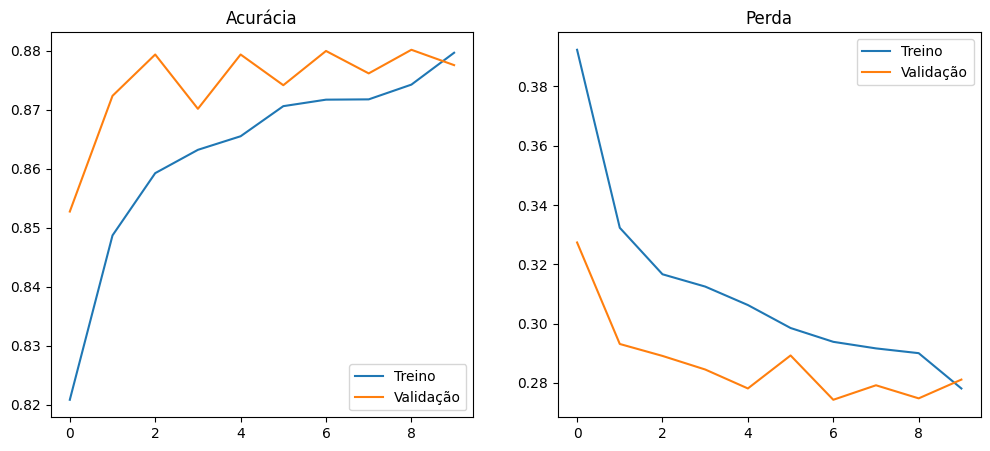

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend()
plt.title("Acurácia")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend()
plt.title("Perda")

plt.show()


##Predição em novas imagens

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "dataset/PetImages/Cat/1.jpg"  # troque por uma imagem
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction[0] > 0.5:
    print("É um cachorro 🐶")
else:
    print("É um gato 🐱")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
É um gato 🐱


## 📊 Resultados e Conclusão
- O modelo apresentou boa acurácia na classificação de **gatos vs cachorros**.  
- A perda de validação diminuiu de forma consistente, indicando bom aprendizado.  

### ✅ Conclusão Final
Este projeto demonstrou a eficácia do **Transfer Learning** em visão computacional.  
Reaproveitando redes pré-treinadas, conseguimos treinar um modelo robusto para classificação binária com menos dados e menor custo computacional.  

🚀 O mesmo conceito pode ser aplicado em diversas áreas: imagens médicas, segurança, e-commerce e muito mais.
